In [22]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from dateutil import parser
from dateutil.relativedelta import relativedelta
from collections import Counter
import math
import cartopy.crs as ccrs
import xarray as xr
from scipy.spatial import KDTree
from geopy import distance

In [23]:
data_location = 'data'
outlooks, pph, reports = read_datasets(data_location)

reading outlooks 1
reading outlooks 2
reading pph
reading storm reports


In [24]:
tz_conversions = {'PST': timedelta(hours=8),
                  'MST': timedelta(hours=7),
                  'CST': timedelta(hours=6),
                  'CSt': timedelta(hours=6),
                  'CSC': timedelta(hours=6),
                  'SCT': timedelta(hours=6),
                  'EST': timedelta(hours=5),
                  'ESt': timedelta(hours=5),
                  'PDT': timedelta(hours=7),
                  'MDT': timedelta(hours=6),
                  'CDT': timedelta(hours=5),
                  'EDT': timedelta(hours=4),
                  'HST': timedelta(hours=10),
                  'SST': timedelta(hours=11),
                  'GST': timedelta(hours=10),
                  'AKS': timedelta(hours=9),
                  'AST': timedelta(hours=4),
                  'UNK': timedelta(hours=5),
                  'GMT': timedelta(0)}

def get_reports_date_strings(date_times, timezones):
    # returns list of strings of date of given datetime and timezone (where day cutoffs are 12-12 UTC) formatted as 'YYYYMMDD0000'
    for datetime, timezone, i in zip(date_times, timezones, range(len(timezones))):
        #print(datetime + ' ' + timezone[:3])
        datetime = parser.parse(datetime)
        datetime = datetime + tz_conversions[timezone[:3]]
        #print(datetime)
        if (datetime.hour < 12):
            datetime = datetime - timedelta(days = 1)
        if datetime.year > 2049:
            datetime = datetime - relativedelta(years = 100)
        datetime = datetime.strftime("%Y%m%d") + '0000'
        if i == 0:
            ret = [datetime]
        else:
            ret.append(datetime)
    return ret

def get_pph_date_strings(times):
    # returns a list of strings of given dates formatted as 'YYYYMMDD0000'
    for datetime, i in zip(times, range(len(times))):
        string = datetime.dt.strftime("%Y%m%d").values + '0000'
        if i == 0:
            ret = [string]
        else:
            ret.append(string)
    return ret

In [25]:
reports['DATE'] = get_reports_date_strings(reports['BEGIN_DATE_TIME'], reports['CZ_TIMEZONE']) 
pph['time'] = get_pph_date_strings(pph.time) 
# subset outlooks into only one day 1, two day 2, and one day 3 categorical outlooks 
# day 3: cycle not -1. day 2: cycle not -1. Day 1: cycle 6. Category: categorical. # TODO: get prob by category 
#outlooks = outlooks[(((outlooks['DAY'] == 1) & (outlooks['CYCLE'] == 6)) | ((outlooks['DAY'] == 2) & (outlooks['CYCLE'] != -1)) | ((outlooks['DAY'] == 3) & (outlooks['CYCLE'] != -1)))
#        & (outlooks['CATEGORY'] == 'CATEGORICAL')]

# reset incicies
outlooks = outlooks.reset_index(drop=True)
reports = reports.drop(columns=['geometry'])

# Gridize reports

In [26]:
# filter reports to only be above severe thresholds

reports.loc[reports['MAGNITUDE'] == '', 'MAGNITUDE'] = 0
reports = reports[(reports['EVENT_TYPE'] == 'Tornado') | 
                  ((reports['EVENT_TYPE'] == 'Thunderstorm Wind') & (reports['MAGNITUDE'].astype(float) >= 50)) |
                  ((reports['EVENT_TYPE'] == 'Hail') & (reports['MAGNITUDE'].astype(float) >= 1))]

In [ ]:
# Create empty reports dataset: same coords and time, 3 hazard dimensions (and total dimension and T/F dimension?)
hazard_types= ['Wind', 'Hail', 'Tornado', 'Sig Wind', 'Sig Hail', 'Sig Tornado', 'Total Reports', 'Total Sig'] 

report_dataset = xr.Dataset(
    data_vars=dict(
        lat=(['y', 'x'], pph['lat'].data),
        lon=(['y', 'x'], pph['lon'].data)
    ),
    coords=dict(
        time=(['time'], pph['time'].data),
        x=(['x'], pph['x'].data),
        y=(['y'], pph['y'].data),
        hazard=(['hazard'], hazard_types)
    ),
    attrs=dict(description="Number of each hazard type",
            grid = pph.grid),
)

report_dataset = report_dataset.assign(count = (('time', 'y', 'x', 'hazard'), np.full((len(report_dataset['time']), len(report_dataset['y']), len(report_dataset['x']), len(hazard_types)), 0)))
report_dataset['count'].mean()

In [ ]:
# https://www.nco.ncep.noaa.gov/pmb/docs/on388/tableb.html#GRID211 APPEARS TO SPECIFY
resolution = 81271
grid_shift = 52
cent_lon = pph['lon'].sel(y=0, x=grid_shift).values
cent_lat = pph['lat'].sel(y=0, x=grid_shift).values
sp = (25, 25)
data_crs = ccrs.LambertConformal(central_latitude = cent_lat, central_longitude=cent_lon, false_easting = 52*resolution, false_northing= 0, standard_parallels=sp)

In [ ]:
kd_tree = KDTree(np.vstack((pph.lat.data.flatten(), pph.lon.data.flatten())).T)
row_len = pph.lat.shape[1]

In [ ]:
# iterate through reports (filtered to only be severe as in labelling), adding 1 to appropriate count 
#               (nearest point? or within 25 mi? would leave out reports in "gap" between 4 25 mi circles. probably within 25 mi for technically correct definition. But can do nearest point and then check within 25 mi.)
tree = True # if using nearest neighbor lookup rather than transforming to NCEP grid, should give same result

for i, row in reports.iterrows(): # for each report
    date = row['DATE']
    if i % 100000 == 0:
        print('Row ' + str(i))
    
    if (date >= report_dataset['time'][0]) and (date <= report_dataset['time'][-1]): # reports in time frame of interest
        # get grid points (x and y) of report location
        lon = row['BEGIN_LON']
        lat = row['BEGIN_LAT']
        if lon != '' and lat != '':
            if not tree:
                x, y = data_crs.transform_point(float(lon), float(lat), src_crs=ccrs.PlateCarree())
            else:
                # Look up nearest with scipy.spatial.KDTree
                index = kd_tree.query((float(lat), float(lon)))[1]
                x, y = (index % row_len, np.floor(index/row_len))
                xgrid, ygrid = x, y

            if not (math.isnan(x) or math.isnan(y) or float(lat) > 90):
                if not tree:
                    x, y = (x/resolution, y/resolution)
                    xgrid = round(x)
                    ygrid = round(y)

                # check if report is within 25 mi of nearest gridpoint
                if not tree:
                    within = np.sqrt((xgrid-x)**2 + (ygrid-y)**2) < .5 and xgrid >= 0 and xgrid <= 92 and ygrid >= 0 and ygrid <= 64 # half a grid point away is 25 miles
                else:
                    nearlat = kd_tree.data[index][0]
                    nearlon = kd_tree.data[index][1]
                    within = distance.distance((lat, lon), (nearlat, nearlon)).miles <= 25  
                
                if within:

                    if row['EVENT_TYPE'] == 'Thunderstorm Wind':
                        report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Wind')] += 1
                        if float(row['MAGNITUDE']) >= 65:
                            report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Sig Wind')] += 1

                    elif row['EVENT_TYPE'] == 'Hail':
                        report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Hail')] += 1
                        if float(row['MAGNITUDE']) >= 2:
                            report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Sig Hail')] += 1

                    elif row['EVENT_TYPE'] == 'Tornado':
                        report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Tornado')] += 1
                        rating_str = row['TOR_F_SCALE']
                        if rating_str != 'EFU' and rating_str != '':
                            if int(rating_str[-1]) >= 2:
                                report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Sig Tornado')] += 1

                    else:
                        raise Exception('Unexpected event type')
            

In [ ]:
# Add total counts and T/F
report_dataset['count'].loc[dict(hazard = 'Total Reports')] = report_dataset['count'].sel(hazard = 'Wind') + report_dataset['count'].sel(hazard = 'Hail') + report_dataset['count'].sel(hazard = 'Tornado')
report_dataset['count'].loc[dict(hazard = 'Total Sig')] = report_dataset['count'].sel(hazard = 'Sig Wind') + report_dataset['count'].sel(hazard = 'Sig Hail') + report_dataset['count'].sel(hazard = 'Sig Tornado')
report_dataset = report_dataset.assign(bool = (('time', 'y', 'x', 'hazard'), (report_dataset['count'] > 0).data))

In [ ]:
save_location = 'data/storm_reports/grid_reports.nc'
report_dataset.to_netcdf(save_location)

# Messing around with projections

In [ ]:
pph['p_perfect_wind'].sum()/100/grid_outlooks.sel(hazard = 'Wind')['bool'].sum()

In [ ]:
grid_outlooks = xr.open_dataset('data/storm_reports/grid_reports.nc')

In [ ]:
pph['p_perfect_tor'].isel(time = pph.time >= '200000000000').mean()/grid_outlooks.sel(hazard = 'Tornado')['bool'].isel(time = grid_outlooks.time >= '200000000000').mean()/100

In [ ]:
# https://www.nco.ncep.noaa.gov/pmb/docs/on388/tableb.html#GRID211 APPEARS TO SPECIFY
from pyproj import Proj, transform
pph = xr.open_dataset('data' + '/pph/' + 'labelled' + '_pph.nc')
resolution = 81271
x_shift = 52
y_shift = 50 # in this test, the central lon and lat come from grid point [52, 0] (or [53, 1], with one-based indexing) in the PPH dataset
cent_lon = pph['lon'].sel(y=y_shift, x=x_shift).values
cent_lat = pph['lat'].sel(y=y_shift, x=x_shift).values
sp = 25# standard parallel


In [ ]:
arrx = np.zeros_like(pph['lat'])
arry = np.zeros_like(pph['lat'])

lcc_proj = Proj(proj='lcc', lat_1=sp, lat_2=sp, lat_0=cent_lat, lon_0=cent_lon, x_0=x_shift * resolution, y_0=y_shift*resolution, datum='WGS84')

for testx in range(93):
    for testy in range(65): # test x and test y (starting with [0, 0]) are the indecies of the grid point from PPH we are comparing against
        x, y = lcc_proj(pph['lon'].sel(x = testx, y = testy).values, pph['lat'].sel(x = testx, y = testy).values) # transforming the lat and lon at this gridpoint from PPH to our newly defined coordinate system should give back [x, y] 
        x, y = (x/resolution, y/resolution) # maybe there's something wrong with this?
        arrx[testy, testx] = x - testx
        arry[testy, testx] = y - testy



In [ ]:
# displaying errors
im = plt.imshow(arry)
plt.title('Y error (number of grid cells)')
plt.colorbar(im)
plt.show()
im = plt.imshow(arrx)
plt.title('X error (number of grid cells)')
plt.colorbar(im)
plt.show()

In [ ]:
go = xr.open_dataset('data/storm_reports/grid_reports.nc')

In [ ]:
(go.lon.values - pph.lon.values).mean()

In [ ]:
(pph.sel(time = '201104260000')['p_perfect_wind']/100).sum()

In [ ]:
go.sel(time = '201104260000', hazard = 'Wind')['bool'].sum()

In [19]:
wpc = pd.read_csv('~/Downloads/2019_wind.csv')

In [ ]:
ncei = pd.read_csv('~/Downloads/2019_ncei.csv')

 to fix: time window/binning

In [ ]:
ncei = ncei[(ncei['BEGIN_DATE_TIME'].str.startswith('20-MAY-19'))]

In [ ]:
ncei = ncei[ncei['EVENT_TYPE'] == 'Thunderstorm Wind']

In [ ]:
wpc = wpc[wpc['date'] == '2019-05-20']

In [21]:
kd_tree = KDTree(np.vstack((pph.lat.data.flatten(), pph.lon.data.flatten())).T)
row_len = pph.lat.shape[1]
# https://www.nco.ncep.noaa.gov/pmb/docs/on388/tableb.html#GRID211 APPEARS TO SPECIFY
resolution = 81271
grid_shift = 52
cent_lon = pph['lon'].sel(y=0, x=grid_shift).values
cent_lat = pph['lat'].sel(y=0, x=grid_shift).values
sp = (25, 25)
data_crs = ccrs.LambertConformal(central_latitude = cent_lat, central_longitude=cent_lon, false_easting = 52*resolution, false_northing= 0, standard_parallels=sp)

NameError: name 'pph' is not defined

In [ ]:
report_dataset = xr.Dataset(
    data_vars=dict(
        lat=(['y', 'x'], pph['lat'].data),
        lon=(['y', 'x'], pph['lon'].data)
    ),
    coords=dict(
        x=(['x'], pph['x'].data),
        y=(['y'], pph['y'].data)
    ),
    attrs=dict(description="Number of each hazard type",
            grid = pph.grid),
)

report_dataset = report_dataset.assign(count = (('y', 'x'), np.full((len(report_dataset['y']), len(report_dataset['x'])), 0)))
report_dataset = report_dataset.assign(bool = (('y', 'x'), np.full((len(report_dataset['y']), len(report_dataset['x'])), 0)))

In [20]:
tree = True
for i, row in wpc.iterrows(): # for each report

    # get grid points (x and y) of report location
    
    #lon = row['BEGIN_LON']
    #lat = row['BEGIN_LAT']
    lon = row['elon']
    lat = row['elat']
    if lon != '' and lat != '':
        if not tree:
            x, y = data_crs.transform_point(float(lon), float(lat), src_crs=ccrs.PlateCarree())
        else:# Look up nearest with scipy.spatial.KDTree
            index = kd_tree.query((float(lat), float(lon)))[1]
            x, y = (index % row_len, np.floor(index/row_len))
            xgrid, ygrid = x, y

        if not (math.isnan(x) or math.isnan(y) or float(lat) > 90):

            if not tree:
                x, y = (x/resolution, y/resolution)
                xgrid = round(x)
                ygrid = round(y)

                # check if report is within 25 mi of nearest gridpoint
                within = np.sqrt((xgrid-x)**2 + (ygrid-y)**2) < .5 and xgrid >= 0 and xgrid <= 92 and ygrid >= 0 and ygrid <= 64 # half a grid point away is 25 miles
            else:
                nearlat = kd_tree.data[index][0]
                nearlon = kd_tree.data[index][1]
                within = distance.distance((lat, lon), (nearlat, nearlon)).miles <= 25 # TODO try turning to always true and see if we get same results as victor  
            
            if within:
                report_dataset['count'].loc[dict(x = xgrid, y = ygrid)] += 1
                report_dataset['bool'].loc[dict(x = xgrid, y = ygrid)] = 1

NameError: name 'kd_tree' is not defined

In [ ]:
(report_dataset['count'] >= 1).sum() # DIFFERENT BECAUSE NOT ACCOUNTING FOR TIME ZONE OR WINDOW!

In [ ]:
lat = pph.lat.values
lon = pph.lon.values

ny, nx = lat.shape

# Vertical distances: between (y, x) and (y+1, x)
vert_dist = np.zeros((ny-1, nx))
for j in range(ny-1):
    for i in range(nx):
        vert_dist[j, i] = distance.distance(
            (lat[j, i], lon[j, i]),
            (lat[j+1, i], lon[j+1, i])
        ).miles

# Horizontal distances: between (y, x) and (y, x+1)
horiz_dist = np.zeros((ny, nx-1))
for j in range(ny):
    for i in range(nx-1):
        horiz_dist[j, i] = distance.distance(
            (lat[j, i], lon[j, i]),
            (lat[j, i+1], lon[j, i+1])
        ).miles

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots()

# Display the data as an image and get the ScalarMappable object
im = ax.imshow(vert_dist, cmap='viridis')

# Add the colorbar, referencing the ScalarMappable object
cbar = fig.colorbar(im, ax=ax)

# Optionally, add a label to the colorbar
cbar.set_label('Data Value')

# Display the plot
plt.show()

In [ ]:
go.sel(time = '201905200000', hazard = 'Wind')['bool'].sum()

In [ ]:
pph.sel(time = '201905200000')['p_perfect_wind'].sum()

In [ ]:
from scipy.ndimage import gaussian_filter

In [ ]:
gaussian_filter(go.sel(time = '201905200000', hazard = 'Wind')['bool']*10000, sigma = 1.5, mode = 'nearest').sum()

In [8]:
from skimage.draw import disk

In [17]:
rr, cc = disk((.45, .45), 1)
rr, cc

(array([0, 0, 1, 1], dtype=int64), array([0, 1, 0, 1], dtype=int64))

In [ ]:
t = '200509140000'
pph.sel(time = t)['p_perfect_tor'].sum().values, go.sel(time = t, hazard = 'Tornado')['bool'].sum().values

In [ ]:
go.sel(time = '201905200000', hazard = 'Tornado')['bool'].sum().values == 20

In [ ]:
for d in pph['time'][8800:]:
    if (pph.sel(time = d)['p_perfect_tor'].sum().values >= 400) and (go.sel(time = d, hazard = 'Tornado')['bool'].sum().values == 1):
        print(d)
# sometimes two reports out of one!

Discrepency example: 200509140000 tornado report

In [ ]:
reports = pd.read_csv('data/storm_reports/all_reports.csv') # from NCEI
reports = pd.read_csv('~/Downloads/2005-2007_torn.csv') # from WCM

In [ ]:
t = '200509140000'
pph.sel(time = t)['p_perfect_tor'].sum().values, go.sel(time = t, hazard = 'Tornado')['bool'].sum().values

In [ ]:
#reports[(reports['DATE'] == '2005-09-14') & (reports['EVENT_TYPE'] == 'Tornado')]
reports[(reports['date'] == '2005-09-14')]

In [ ]:
#lat = reports[(reports['DATE'] == '2005-09-14') & (reports['EVENT_TYPE'] == 'Tornado')].BEGIN_LAT.values[0] # '2005-09-14'
#lon = reports[(reports['DATE'] == '2005-09-14') & (reports['EVENT_TYPE'] == 'Tornado')].BEGIN_LON.values[0]

lat = reports[(reports['date'] == '2005-09-14')].slat.values[0] # '2005-09-14'
lon = reports[(reports['date'] == '2005-09-14')].slon.values[0]

In [ ]:
lat, lon

In [ ]:
mindist = np.inf
for x in pph['x']:
    for y in pph['y']:
        latp = pph['lat'].sel(x = x, y = y)
        lonp = pph['lon'].sel(x = x, y = y)
        dist = distance.distance((lat, lon), (latp, lonp)).miles
        if dist < mindist:
            mindist = dist
            savex = x
            savey = y

For each day with exactly one report, check total pph and storm reports on that day, and distance of that report to nearest gridpoint

In [75]:
gr = xr.open_dataset('data/storm_reports/grid_reports.nc')

In [76]:
reports = reports[reports['DATE'] > '200202280000']
reports = reports.sort_values('DATE')

pph_key_dict = {
    'Wind': 'p_perfect_wind',
    'Hail': 'p_perfect_hail',
    'Tornado': 'p_perfect_tor',
    'All Hazard': 'p_perfect_totalsvr'
}

In [80]:
dates = []
dists = []
pph_vals = []
report_vals = []
ets = []

kd_tree = KDTree(np.vstack((pph.lat.data.flatten(), pph.lon.data.flatten())).T)

In [90]:
curryear = None
event_types = ['Tornado', 'Hail', 'Wind']
for date in (reports['DATE']).unique():
    year = date[:6]
    if year != curryear:
        year_reports = reports[list(map(lambda x: x.startswith(year), reports['DATE'])) ]
        print(year)
        curryear = year
    for et in event_types:
        if et == 'Wind':
            e = 'Thunderstorm Wind'
        else:
            e = et
        this_reports = year_reports[(year_reports['DATE'] == date) & (year_reports['EVENT_TYPE'] == e)]
        if len(this_reports) == 1:
            #print(date, e)
            lat = this_reports.BEGIN_LAT.values[0] 
            lon = this_reports.BEGIN_LON.values[0] 
            if lat != '':

                index = kd_tree.query((float(lat), float(lon)))[1]
                latp = kd_tree.data[index][0]
                lonp = kd_tree.data[index][1]
                mindist = distance.distance((lat, lon), (latp, lonp)).miles
            
                #print(mindist)
                pph_sum = pph.sel(time = date)[pph_key_dict[et]].sum().values / 100
                #print(pph_sum)
                report_sum = gr.sel(time = date, hazard = et)['bool'].sum().values
                #print(report_sum)
                dates.append(date)
                dists.append(mindist)
                pph_vals.append(pph_sum)
                report_vals.append(report_sum)
                ets.append(e)

    #if only one report:
        # calculate distance and save
        # pull reports bool count
        # pull pph sum


200203
200204
200205
200206
200207
200208
200209
200210
200211
200212
200301
200302
200303
200304
200305
200306
200307
200308
200309
200310
200311
200312
200401
200402
200403
200404
200405
200406
200407
200408
200409
200410
200411
200412
200501
200502
200503
200504
200505
200506
200507
200508
200509
200510
200511
200512
200601
200602
200603
200604
200605
200606
200607
200608
200609
200610
200611
200612
200701
200702
200703
200704
200705
200706
200707
200708
200709
200710
200711
200712
200801
200802
200803
200804
200805
200806
200807
200808
200809
200810
200811
200812
200901
200902
200903
200904
200905
200906
200907
200908
200909
200910
200911
200912
201001
201002
201003
201004
201005
201006
201007
201008
201009
201010
201011
201012
201101
201102
201103
201104
201105
201106
201107
201108
201109
201110
201111
201112
201201
201202
201203
201204
201205
201206
201207
201208
201209
201210
201211
201212
201301
201302
201303
201304
201305
201306
201307
201308
201309
201310
201311
201312
201401

In [126]:
df = pd.DataFrame({
    'date': dates,
    'distances': dists,
    'pph': pph_vals,
    'reports': report_vals,
    'type': ets
})

df.to_csv('pph_report_discrpency.csv', index=False)

In [130]:
df['date'] = pd.to_datetime(df['date'], format="%Y%m%d%H%M")
df['pph'] = df['pph'].astype(float)
df['reports'] = df['reports'].astype(float)
df['year'] = df['date'].dt.year
df['near'] = df['distances'] <= 25

In [131]:
df.groupby(['type', df['distances'] <= 25])[['pph','reports']].mean()

pph  reports
type              distances                   
Hail              False      1.005090      0.0
                  True       0.996795      1.0
Thunderstorm Wind False      1.057267      0.0
                  True       1.049587      1.0
Tornado           False      0.979454      0.0
                  True       0.940705      1.0

In [138]:
yearly = (
    df.groupby(['year', 'type', 'near'])[['pph', 'reports']]
      .mean()
      .reset_index()
)
hazards = df['type'].unique()

label_map = {
    True: "≤25 km",
    False: ">25 km"
}

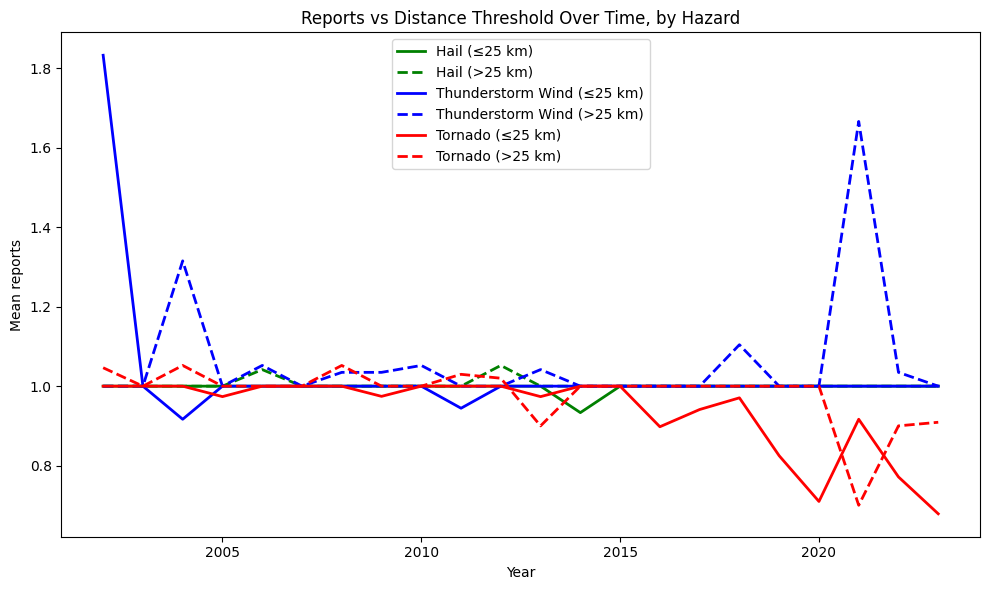

In [139]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = {
    "Tornado": "red",
    "Hail": "green",
    "Thunderstorm Wind": "blue"
}

linestyles = {
    True: "-",
    False: "--"
}

for hazard in hazards:
    for near_flag in [True, False]:
        sub = yearly[(yearly['type'] == hazard) &
                     (yearly['near'] == near_flag)]
        
        if len(sub) == 0:
            continue

        ax.plot(
            sub['year'],
            sub['pph'],     # <-- change to 'pph' if you prefer
            label=f"{hazard} ({label_map[near_flag]})",
            color=colors[hazard],
            linestyle=linestyles[near_flag],
            linewidth=2
        )

ax.set_xlabel("Year")
ax.set_ylabel("Mean reports")
ax.set_title("Reports vs Distance Threshold Over Time, by Hazard")
ax.legend()
plt.tight_layout()
plt.show()